In [1]:
import sys
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import patches

import cv2
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch import nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils import data as torch_data
from torchvision import transforms as T
import torch.nn.functional as F

from torch.utils.data import Dataset
from PIL import Image 
from xml.etree import ElementTree as ET
import glob 
from torch.utils.data import DataLoader
from copy import deepcopy


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 시각화

In [3]:
def get_image(annot):
    img_path = '/kaggle/input/stanford-dogs-dataset/images/Images/'
    file = annot.split('/')
    img_filename = img_path + file[-2]+'/'+file[-1]+'.jpg'
    return img_filename

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  if __name__ == "__main__":


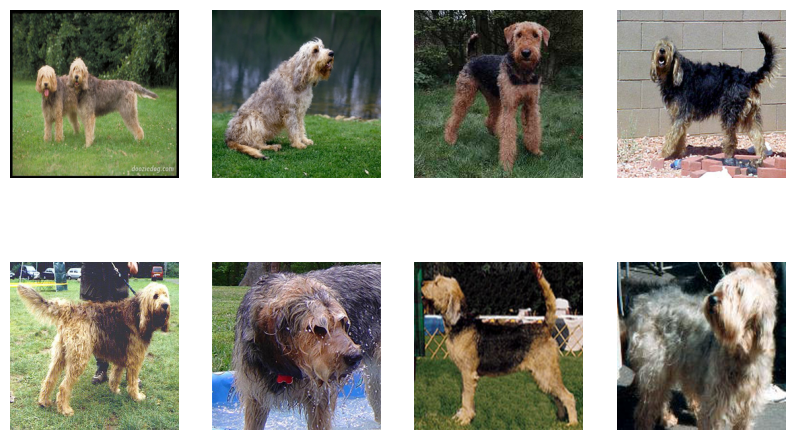

In [7]:
annotations = glob.glob('/kaggle/input/stanford-dogs-dataset/annotations/Annotation/*/*')

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    dog = get_image(annotations[i])
    im = Image.open(dog)
    im = im.resize((256,256), Image.ANTIALIAS)
    plt.imshow(im)

In [4]:
root_dir = '/kaggle/input/stanford-dogs-dataset/'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [5]:
import os

labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=3)[-1]] = i

In [6]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

In [7]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.annot_dir = sorted(annot_dir)
        self.img_dir = sorted(img_dir)
        self.transform = transform
   
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label, img = img_crop(annot_path, img)
        
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img
            
        sample = {'image': img, 'label': label}
        return sample

In [8]:
data_transform = A.Compose([A.Resize(224, 224), A.Normalize(),ToTensorV2()])

In [9]:
image_dataset = DogsDataset(annot_dir ='/annotations/Annotation/',
                            img_dir ='/images/Images/', transform=data_transform)

In [11]:
len(image_dataset)

20580

In [12]:
image_dataset[0]['label']

71

In [13]:
image_dataset[0]["image"].shape

torch.Size([3, 224, 224])

In [14]:
image_dataset[0]["label"]

71

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

total_label = [data['label'] for data in image_dataset]

trainset_idx, testset_idx = train_test_split(range(len(image_dataset)),
                test_size=0.2, random_state=42, shuffle=True, stratify=total_label)

# 전체 데이터 셋에서 train과 test로 나누기
train_set = Subset(image_dataset, trainset_idx)
test_set = Subset(image_dataset, testset_idx)

# train label
train_label = [data['label'] for data in train_set]

# train idx와 valid idx
trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, shuffle=True, stratify=train_label)

# train set에서 train과 valid로 나누기
from torch.utils.data import Subset
trainset = Subset(train_set, trainset_idx)
validset = Subset(train_set, validset_idx)

In [16]:
print(type(trainset), len(trainset))
print(type(validset), len(validset))
print(type(test_set), len(test_set))

<class 'torch.utils.data.dataset.Subset'> 13171
<class 'torch.utils.data.dataset.Subset'> 3293
<class 'torch.utils.data.dataset.Subset'> 4116


In [17]:
print(trainset[0]['image'].shape)
print(validset[0]['image'].shape)
print(test_set[0]['image'].shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [18]:
batch_size = 16 # 100 -> 16
# dataloader = DataLoader(데이터셋, 배치사이즈, 셔플여부.....)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용 13171개의 데이터를 100개씩 준비
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용 10000개의 데이터를 100개씩 준비
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False) # 테스트용 10000개의 데이터를 100개씩 준비

In [19]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 824
<class 'torch.utils.data.dataloader.DataLoader'> 206
<class 'torch.utils.data.dataloader.DataLoader'> 258


In [20]:
13171/16, 3293/16, 4116/16

(823.1875, 205.8125, 257.25)

In [21]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), batch['label'].shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [22]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

In [23]:
import torchvision.models as models

model = models.resnet50(weights=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [24]:
for parameter in model.parameters():
  print(parameter.requires_grad)
# parameter들의 requires_grad 속성이 true라는 것은 오차역전파를 통해 gradient를 전달할 수 있는 상태(즉, 학습이 가능한 상태)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [28]:
for parameter in model.parameters():
    parameter.requires_grad = False # 학습이 안되게 고정

    for parameter in model.fc.parameters():
        parameter.requires_grad = True # 학습이 가능한 상태 

In [29]:
# model.classifier[3] = nn.Linear(in_features=4096, out_features=512, bias=True)
# model.classifier[6] = nn.Linear(in_features=512, out_features=2, bias=True)
model.fc = nn.Linear(in_features=2048, out_features=120, bias=True)

In [30]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
out = model(batch['image'].to(device))
out.shape

torch.Size([16, 120])

In [33]:
for name, parameter in model.named_parameters():
    print(name, parameter.size())

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [34]:
learning_rate = 0.0001
# 손실함수
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저(최적화함수, 예:경사하강법)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 규제의 강도 설정 weight_decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

# Learning Rate Schedule
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

# 모니터링하고 있는 값(예:valid_loss)의 최소값(min) 또는 최대값(max) patience 기간동안 줄어들지 않을 때(OnPlateau) lr에 factor(0.1)를 곱해주는 전략
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

In [35]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
    with torch.no_grad():
        for batch in validloader:# 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
          # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
          # 0. Data를 GPU로 보내기
            images = batch['image']
            labels = batch['label']
            
            images, labels = images.to(device), labels.to(device)
            
            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.size()[0], 784)
  
            # 2. 전방향(Forward) 예측
            logit = model(images) # 예측 점수
            _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
            # preds = logit.max(dim=1)[1] 
            correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
            total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

            loss = loss_fn(logit, labels)
            valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [36]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
    steps = 0
    steps_per_epoch = len(trainloader) 
    min_loss = 1000000
    max_accuracy = 0
    trigger = 0
    patience = 7 

    for epoch in range(epochs):
        model.train() # 훈련 모드
        train_loss = 0
        for batch in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
            steps += 1
            # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            # 0. Data를 GPU로 보내기
            images = batch['image']
            labels = batch['label']
            images, labels = images.to(device), labels.to(device)

            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.shape[0], 784) 

            # 2. 전방향(forward) 예측
            predict = model(images) # 예측 점수
            loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환

            # 3. 역방향(backward) 오차(Gradient) 전파
            optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
            loss.backward() # 모델파리미터들의 Gradient 전파

            # 4. 경사 하강법으로 모델 파라미터 업데이트
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0 : 
                model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)
            # -------------------------------------------

                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                   'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                   'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                   'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
                      )

              # Best model 저장    
              # option 1 : valid_loss 모니터링
              # if valid_loss < min_loss: # 바로 이전 epoch의 loss보다 작으면 저장하기
              #   min_loss = valid_loss
              #   best_model_state = deepcopy(model.state_dict())          
              #   torch.save(best_model_state, 'best_checkpoint.pth')     

              # option 2 : valid_accuracy 모니터링      
                if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
                    max_accuracy = valid_accuracy
                    best_model_state = deepcopy(model.state_dict())          
                    torch.save(best_model_state, 'best_checkpoint.pth')  
              # -------------------------------------------

              # Early Stopping (조기 종료)
                if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
                    trigger += 1
                    print('trigger : ', trigger)
                if trigger > patience:
                    print('Early Stopping !!!')
                    print('Training loop is finished !!')
                    return
                else:
                    trigger = 0
                    min_loss = valid_loss
                # -------------------------------------------

                # Learning Rate Scheduler
                scheduler.step(valid_loss)
            # -------------------------------------------

    return  

In [37]:
epochs = 55
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

Epoch : 1/55....... Train Loss : 3.246 Valid Loss : 1.791 Valid Accuracy : 0.756
Epoch : 2/55....... Train Loss : 1.619 Valid Loss : 1.062 Valid Accuracy : 0.805
Epoch : 3/55....... Train Loss : 1.121 Valid Loss : 0.825 Valid Accuracy : 0.816
Epoch : 4/55....... Train Loss : 0.904 Valid Loss : 0.717 Valid Accuracy : 0.812
Epoch : 5/55....... Train Loss : 0.787 Valid Loss : 0.622 Valid Accuracy : 0.837
Epoch : 6/55....... Train Loss : 0.708 Valid Loss : 0.590 Valid Accuracy : 0.836
Epoch : 7/55....... Train Loss : 0.651 Valid Loss : 0.588 Valid Accuracy : 0.830
Epoch : 8/55....... Train Loss : 0.610 Valid Loss : 0.549 Valid Accuracy : 0.841
Epoch : 9/55....... Train Loss : 0.581 Valid Loss : 0.542 Valid Accuracy : 0.837
Epoch : 10/55....... Train Loss : 0.552 Valid Loss : 0.532 Valid Accuracy : 0.834
Epoch : 11/55....... Train Loss : 0.523 Valid Loss : 0.510 Valid Accuracy : 0.844
Epoch : 12/55....... Train Loss : 0.502 Valid Loss : 0.534 Valid Accuracy : 0.835
trigger :  1
Epoch : 13/5